In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import  GridSearchCV  
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import LabelEncoder

import nltk

import spacy

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Importing all the datasets
train_A = pd.read_csv('train_A.csv')
train_B = pd.read_csv('train_B.csv')
train_C = pd.read_csv('train_C.csv')

val_A = pd.read_csv('val_A.csv')
val_B = pd.read_csv('val_B.csv')
val_C = pd.read_csv('val_C.csv')

test_A = pd.read_csv('test_A.csv')
test_B = pd.read_csv('test_B.csv')
test_C = pd.read_csv('test_C.csv')

In [3]:
# Concatting datasets

train_AB = train_A.merge(train_B, how='left', on=['char', 'dialog'])
train_AC = train_A.merge(train_C, how='left', on=['char', 'dialog'])

val_AB = val_A.merge(val_B, how= 'left', on=['char', 'dialog'])
val_AC = val_A.merge(val_C, how= 'left', on=['char', 'dialog'])

test_AB = test_A.merge(val_B, how= 'left', on=['char', 'dialog'])
test_AC = test_A.merge(val_C, how= 'left', on=['char', 'dialog'])

In [4]:

datasets = [train_A, val_A, test_A, train_B, val_B, test_B, train_C, val_C, test_C,
             train_AB, val_AB, test_AB, train_AC, val_AC, test_AC]


## Character prediction
### Divide and conquer; Preprocessing steps for the datasets

In [5]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "ARAGORN"]

# Creating a common label for the characters not of interest
def common_label_removal(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data

def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    print(names)
    print(np.unique(encoded_data))
    return encoded_data, names

def preprocessing(data):
    data = common_label_removal(data)
    x_data, y_data = x_y_split(data)
    y_data = char_2_num(y_data)
    return x_data, y_data

for i in range(len(datasets)):
    datasets[i] = preprocessing(datasets[i])



['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 

In [13]:
datasets[0][1]

(array([2, 8, 7, ..., 3, 8, 0]),
 ['ARAGORN',
  'FARAMIR',
  'FRODO',
  'GANDALF',
  'GIMLI',
  'GOLLUM',
  'MERRY',
  'PIPPIN',
  'SAM',
  'THEODEN'])

### Naive Benchmark model

In [6]:
eval_methods = [ f1_score, precision_score, recall_score]

def naive_model(x_data, y_data):
    accuracies = []
    for i in range(1000):
        pred = np.random.randint(0, 12, size=len(x_data))
        accuracies.append(accuracy_score(y_data, pred))
    avg_pred = np.mean(accuracies)

    print("Average Accuracy ", round(avg_pred, 4))
    print(classification_report(y_data, pred))
     
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return avg_pred   

naive_predicitons = naive_model(lotr_test_X, lotr_test_Y)

NameError: name 'lotr_test_X' is not defined

### Random Forest Classifier
ON DATASET "A"

In [ ]:

def optimize_model_parameters(X_train, y_train, model, param_grid, cv=5):
 
    rfc = model()

    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_score)


    optimized = model(**best_params)
    optimized.fit(X_train, y_train)
    return optimized


param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [ 5, 10, 15],
    #'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Optimize parameters
optimized_rf = optimize_model_parameters(lotr_train_X, lotr_train_Y, RFC, param_grid)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 25}
Best Accuracy Score: 0.20569546395633354


In [ ]:
def evaluate_model(x_data, y_data, model):

    pred = model.predict(x_data)
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred  

rfc_predictions = evaluate_model(lotr_test_X, lotr_test_Y, optimized_rf) 

              precision    recall  f1-score   support

           0       0.11      0.11      0.11        28
           1       0.00      0.00      0.00         6
           2       0.27      0.29      0.28        41
           3       0.23      0.36      0.28        33
           4       0.00      0.00      0.00        17
           5       0.07      0.12      0.09         8
           6       0.00      0.00      0.00        14
           7       0.18      0.17      0.17        24
           8       0.26      0.16      0.20        37
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        10
          11       0.18      0.19      0.18        16

    accuracy                           0.17       236
   macro avg       0.11      0.12      0.11       236
weighted avg       0.17      0.17      0.17       236

Accuracy  0.1737
f1_score 0.1654
precision_score 0.1656
recall_score 0.1737


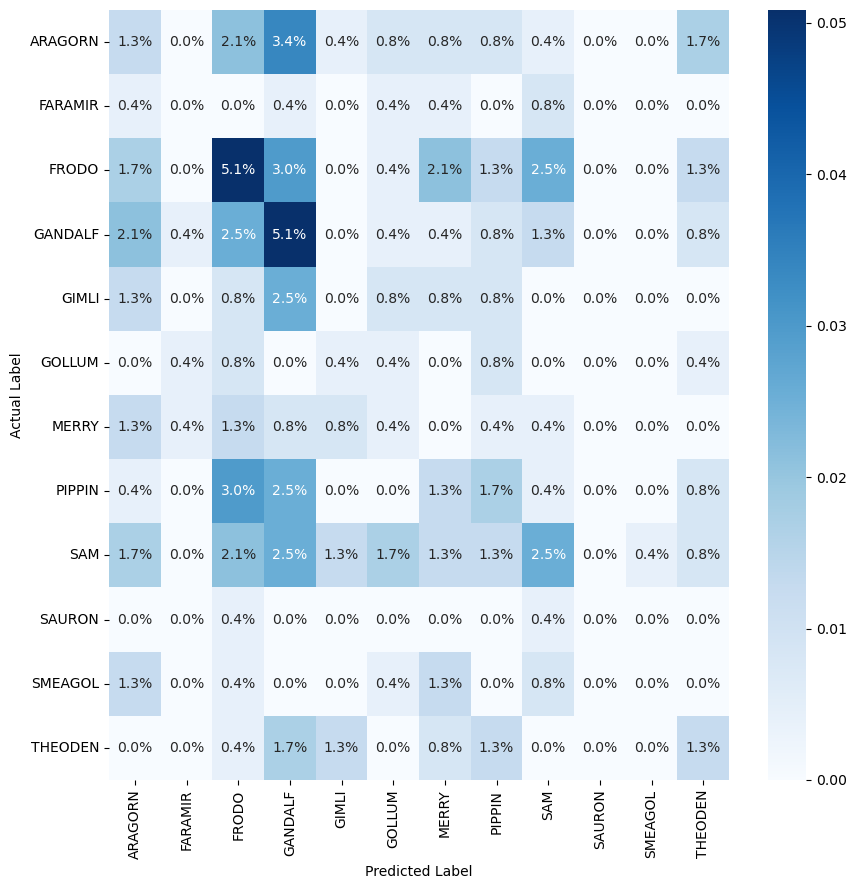

In [ ]:

def conf_matrix(y, pred):
    cm = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=names, yticklabels=names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

conf_matrix(lotr_test_Y, rfc_predictions)

ON DATASET "A+B"

In [ ]:
test_w2v = pd.read_csv('test_B.csv')
train_w2v = pd.read_csv('train_B.csv')


lotr_train_X.reset_index(drop=True, inplace=True)
lotr_test_X.reset_index(drop=True, inplace=True)

train_rfc_X = pd.concat([lotr_train_X, train_w2v], axis=1)
test_rfc_X = pd.concat([lotr_test_X, test_w2v], axis=1)

In [ ]:
train_rfc_X 

,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,topic,trust,...,word_161,word_162,word_163,word_164,word_165,word_166,word_167,word_168,word_169,word_170
0,1.0,10.0,0.0,0.0,0.0,0.0,1.0,0.000,2.0,0.0,...,100,100,100,100,100,100,100,100,100,100
1,8.0,49.0,2.0,1.0,0.0,0.0,8.0,0.125,4.0,0.0,...,100,100,100,100,100,100,100,100,100,100
2,4.0,24.0,0.0,0.0,1.0,0.0,4.0,0.500,4.0,0.0,...,100,100,100,100,100,100,100,100,100,100
3,1.0,11.0,0.0,0.0,0.0,1.0,1.0,0.000,2.0,0.0,...,100,100,100,100,100,100,100,100,100,100
4,13.0,72.0,4.0,1.0,0.0,4.0,13.0,-0.375,5.0,0.0,...,100,100,100,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,100,100,100,100
1668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,100,100,100,100
1669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,100,100,100,100
1670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,100,100,100,100


In [ ]:
optimized_rf2 = optimize_model_parameters(train_rfc_X, lotr_train_Y, RFC, param_grid)
rfc2_predictions = evaluate_model(test_rfc_X, lotr_test_Y, optimized_rf2) 
conf_matrix(lotr_test_Y, rfc2_predictions)

ValueError: Found input variables with inconsistent numbers of samples: [1672, 1152]

ON DATASET "A+C"

In [ ]:
test_C = pd.read_csv('test_C.csv')
val_C = pd.read_csv('test_C.csv')
train_C = pd.read_csv('train_C.csv')


train_AC_X = pd.concat([lotr_train_X, train_C], axis=1)
val_AC_X = pd.concat([lotr_test_X, val_C], axis=1)
test_AC_X = pd.concat([lotr_test_X, test_C], axis=1)

In [ ]:
train_C

,top,cage,doubt,nai,could,doorway,invis,sgo,rather,fast,...,huh,mile,unchalleng,bare,bore,given,saferthan,understand,thorin,enna
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
optimized_rf2 = optimize_model_parameters(train_AC_X, lotr_train_Y, RFC, param_grid)
rfc2_predictions = evaluate_model(test_AC_X, lotr_test_Y, optimized_rf2) 
conf_matrix(lotr_test_Y, rfc2_predictions)

ValueError: Found input variables with inconsistent numbers of samples: [1672, 1152]